# Regularization: L2 and L1, aka Ridge regression or weight decay, and Lasso

In this notebook we explore two different regularization strategies, and through illustration, indicate what each might be good for.

In [4]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
import pandas as pd
from pandas import DataFrame, Series
import seaborn as sns
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
sns.set(style='ticks', palette='Set2')
%matplotlib inline

Recall that the Ordinary Least Squares (OLS) regression solution for the linear model $y = X\beta + e$, is given by

$$
\arg\min_{\beta}: \,\, \|X \beta - y\|_2^2 = \arg\min_{\beta}{\rm SSE}(\beta)
$$

Regularization adds a penalty. Ridge regression adds a squared penalty which serves to regularize and shrink the coefficients:

$$
\arg\min_{\beta}{\rm SSE}(\beta) + \lambda \sum \beta_i^2 = \arg\min_{\beta}{\rm SSE}(\beta) + \lambda \|\beta\|_2^2
$$

# Some Examples

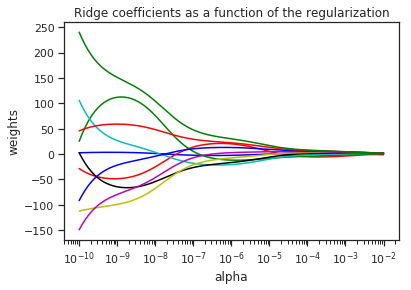

In [9]:
# A first (stylized) example of what Ridge Regression does

# We generate the data
# X is the 10x10 Hilbert matrix
X = 1. / (np.arange(1, 11) + np.arange(0, 10)[:, np.newaxis])
y = np.ones(10) + np.random.rand(10)/100


# then we plot the results
n_alphas = 200
alphas = np.logspace(-10, -2, n_alphas)
clf = linear_model.Ridge(fit_intercept=False)

coefs = []
for a in alphas:
    clf.set_params(alpha=a)
    clf.fit(X, y)
    coefs.append(clf.coef_)

###############################################################################
# Display results

ax = plt.gca()
ax.set_prop_cycle(color=['b', 'r', 'g', 'c', 'k', 'y', 'm'])

ax.plot(alphas, coefs)
ax.set_xscale('log')
#ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

# Another example: Correlated / Co-linear columns

In [21]:
# correlated columns
# Suppose p = 5, n = 500 -- a good ratio
p = 5; n = 500
X = np.random.randn(n,p)
c = np.dot(X[:,0:p-1],[2,3,-1,0.5]) + np.random.randn(1,n)/1000;
# c is a column that is approximately a linear combination of
# columns 1, 2, 3 and 4. We set the 5th column of X equal to c
X[:,p-1] = c
beta = np.array([1,1,1,1,0])
sigma = 0.3333
y = np.dot(X,beta) + sigma*np.random.randn(n)
# Now let's also generate a test data set
n1 = 500 # number of testing points
X_test = np.random.randn(n1,p)
c_test = np.dot(X[:,0:p-1],[2,3,-1,0.5]) + np.random.randn(1,n)/1000;
X_test[:,p-1] = c
y_test = np.dot(X_test,beta) + sigma*np.random.randn(n1)

In [22]:
# Note that the matrix Z = X'X has a very small eigenvalue.
Z = np.dot(X.T,X)
np.linalg.eig(Z)[0]

array([7.54506493e+03, 3.27839627e-05, 5.95632077e+02, 5.12093052e+02,
       4.69143550e+02])

In [23]:
# That means that its inverse has some very big eigenvalues.
# In fact, recall that the eigenvalues of the inverse matrix
# are always the inverse (one over) the eigenvalues of the original
# matrix.
np.linalg.eig(np.linalg.inv(Z))[0]

array([3.05027189e+04, 1.32536964e-04, 2.13154375e-03, 1.95277010e-03,
       1.67888876e-03])

In [24]:
# And remember that the formula for beta is
# beta_hat = (X'X)^-1 X'y
# and if we plug in: y = X beta* + Noise 
# (where beta* is the true solution), we get
# beta_hat = beta* + (X'X)^-1 X' Noise
#
# Multiplying the noise by (X'X)^-1 has the potential to blow up the noise
# and this is exactly what happens.

beta_hat = np.dot(np.dot(np.linalg.inv(Z),X.T),y.T)
print(beta_hat)

[-22.65577543 -34.47023596  12.78974855  -4.91089031  11.81937523]


To see that this is indeed "noise applification" go up a few cells and set sigma = 0 (it's set to 0.333 in the original version of this notebook). When you do that, you are setting the additive error in "y = X \beta + Noise" to zero. Hence there is no noise to amplify. Hence there are no problems with the huge eigenvalues of (X'X)^-1, and we still recover the correct answer. But even a little bit of error, and this goes out the window.

In [25]:
# Now let's compute the test error of OLS.
# You can see that it's not that good (it's big).
np.linalg.norm(np.dot(X_test,beta_hat) - y_test)

1386.5483376694383

In [26]:
# For comparison, the true error for the optimal beta is:
np.linalg.norm(np.dot(X_test,beta) - y_test)

7.217297546780687

In [38]:
# Now we will add some regularization -- aka weight decay.
# Linear regression plus weight decay also has a closed form solution:
#
# beta_hat_R = (X'X + mu I)^-1 X'y -- compare to beta_hat = (X'X)^-1 X'y
# where I is the p by p identity matrix.
# 
# Adding a small multiple of the identity to X'X barely changes the large eigenvalues, 
# but it drastically changes the smallest eigenvalue -- it increases it to mu.
# Thus in the inverse, the largest eigenvalue will be at most 1/mu.
# Let's see this in action
#
mu = 0.15
print(np.linalg.eig(Z)[0])
print(np.linalg.eig(Z + mu*np.eye(p))[0])

[7.54506493e+03 3.27839627e-05 5.95632077e+02 5.12093052e+02
 4.69143550e+02]
[7.54521493e+03 1.50032784e-01 5.95782077e+02 5.12243052e+02
 4.69293550e+02]


In [39]:
# Now we can form the solution to the weight-decay problem, using
# the closed-form formula from above
beta_hat_R = np.dot(np.dot(np.linalg.inv(Z + mu*np.eye(p)),X.T),y.T)
print(beta_hat_R)

[0.39349203 0.10301511 1.26541552 0.85160277 0.29493517]


Note that in the above, the values are all much more controlled. There is no "error explosion" as in the OLS case. You may ask, however: why don't we recover the solution beta* = [1,1,1,1,0]? 

In fact, we cannot. Think about a case where two columns (say, columns 1 and 2) are identical. Then there's nothing the data can do to differentiate between putting weight on column 1 or column 2 or somehow splitting it between the two. {\em Any of these options produces exactly the same prediction function}. And note that since column 5 is twice the first plus 3 times the second minus the third plus 1/2 times the fourth, we have above precisely the right solution: 0.53794428 + 2 * 0.23421377 is approximately 1. 0.30061129 + 3 * 0.23421377 is approximately 1. 1.2239305 - 0.23421377 is approximately 1. And 0.87410259 + (1/2)*0.23421377 is approximately 1.

In [40]:
# Finally, let's compute the test error for the ridge regression solution.
np.linalg.norm(np.dot(X_test,beta_hat_R) - y_test)

34.76263755931145

In [30]:
# Let's again see the original solution, 
# the OLS solution (noise explosion), and the weight-decay version
# (aka ridge regression)
print(beta)
print(beta_hat)
print(beta_hat_R)

[1 1 1 1 0]
[-22.65577543 -34.47023596  12.78974855  -4.91089031  11.81937523]
[ 0.32329527 -0.00240866  1.30092047  0.83424771  0.33009177]


In [31]:
# And let's again print the test error for the original solution,
# the OLS solution (and hence the impact of noise explosion)
# and then the weight-decay (ridge regression) version.
#
# As you can see, the Ridge-Regression solution has test error
# far far closer to the error of the true solution, than
# the OLS solution does.

print(np.linalg.norm(np.dot(X_test,beta) - y_test))
print(np.linalg.norm(np.dot(X_test,beta_hat) - y_test))
print(np.linalg.norm(np.dot(X_test,beta_hat_R) - y_test))

7.217297546780687
1386.5483376694383
38.806385453953105


# Encouraging sparse solutions: L1 regularization and Lasso

In the same way that in Ridge regression we modify the objective, here too we do the same thing, and again with a regularizer. Instead of using the squared Euclidean norm, we use the so-called L1 norm. Thus, instead of solving for the minimizer of the Sum of the Squared Error (SSE), we solve:

$$
\min_{\beta}:\,\, {\rm SSE}(\beta) + \lambda \sum |\beta_i| =  {\rm SSE}(\beta) + \lambda \|\beta\|_1.
$$

Why should we expect this to encourage sparsity?

In [50]:
# generate some sparse data to play with
np.random.seed(7)

n_samples, n_features = 100, 200
X = np.random.randn(n_samples, n_features)

k = 5
# beta generated with k nonzeros
#coef = 10 * np.random.randn(n_features)
coef = 10 * np.ones(n_features)
inds = np.arange(n_features)
np.random.shuffle(inds)
coef[inds[k:]] = 0  # sparsify coef
y = np.dot(X, coef)

# add noise
y += 0.01 * np.random.normal((n_samples,))

# Split data in train set and test set
n_samples = X.shape[0]
X_train, y_train = X[:50], y[:50]
X_test, y_test = X[50:], y[50:]

# Exercise: use (1) Ordinary Least Squares, (2) Regression, and (3) Lasso, to see what each is doing with respect to sparsity. Compute the $R^2$ values for each, and also plot the coefficients vs the true coefficients.

In [80]:
# Standard Regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
#OLS = LinearRegression()
#OLS.fit(X_train,y_train).predict(X_test)
# Rather than rely on LinearRegression() to compute my OLS solution,
# I am using the closed form expression to compute it directly:
# beta_OLS = X'(XX')^-1 y -- note that it is a different form than
# above, because we are using the closed form for when n < d.
#
Z = np.dot(X_train,X_train.T)
invZ = np.linalg.inv(Z)
beta_OLS = np.dot(np.dot(X_train.T,invZ),y_train)
#y_pred_OLS = OLS.fit(X_train, y_train).predict(X_test)
y_pred_OLS = np.dot(X_test,beta_OLS)

R^2 on test data : 0.067191


In [84]:
# let's check the training error of OLS: we should expect = 0
# because even though there is additive error, we have n < d
# and hence we should also be able to fit that noise (typically not a good thing)
#
np.linalg.norm(np.dot(X_train,beta_OLS) - y_train)

1.0230956670789823e-13

In [86]:
# Now we can compute the fit on the testing data
# and also compute the so-called R^2 score
testing_loss_OLS = np.linalg.norm(np.dot(X_test,beta_OLS) - y_test)
print("Testing loss of the OLS solution : %f" % testing_loss_OLS)
# And we compare it to the testing loss of the true solution
true_loss_OLS = np.linalg.norm(np.dot(X_test,coef) - y_test)
print("Testing loss of the true (ground truth) solution : %f" % true_loss_OLS)
r2_score_OLS = r2_score(y_test, y_pred_OLS)
#print(OLS)
print("R^2 on test data : %f" % r2_score_OLS)

Testing loss of the OLS solution : 111.375596
Testing loss of the true (ground truth) solution : 7.060902
R^2 on test data : 0.067191


The $R^2$ value is not very good. Let's see what the coefficients look like compared to the true coefficients.

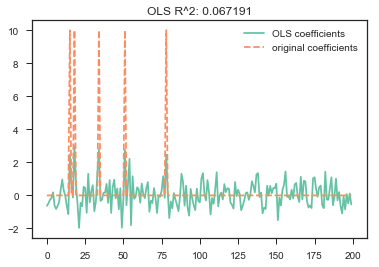

In [81]:
plt.plot(OLS.coef_, label='OLS coefficients')
plt.plot(coef, '--', label='original coefficients')
plt.legend(loc='best')
plt.title("OLS R^2: %f"
          % (r2_score_OLS))
plt.show()

In [54]:
# Ridge regression / weight decay
from sklearn.linear_model import Ridge
alpha = 0.1
ridge = Ridge(alpha = alpha)
ridge.fit(X_train,y_train)
y_pred_ridge = ridge.fit(X_train, y_train).predict(X_test)
r2_score_ridge = r2_score(y_test, y_pred_ridge)
#print(lasso)
print("R^2 on test data : %f" % r2_score_ridge)

R^2 on test data : 0.021525


Again, the $R^2$ value is not very good. Let's see what the coefficients look like compared to the true coefficients.

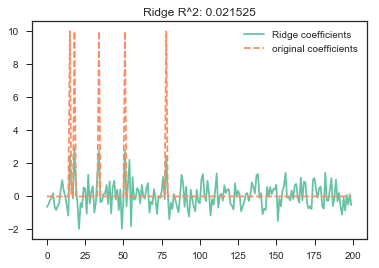

In [55]:
plt.plot(ridge.coef_, label='Ridge coefficients')
plt.plot(coef, '--', label='original coefficients')
plt.legend(loc='best')
plt.title("Ridge R^2: %f"
          % (r2_score_ridge))
plt.show()

In [56]:
# Lasso
from sklearn.linear_model import Lasso

alpha = 3
lasso = Lasso(alpha=alpha)

y_pred_lasso = lasso.fit(X_train, y_train).predict(X_test)
r2_score_lasso = r2_score(y_test, y_pred_lasso)
#print(lasso)
print("R^2 on test data : %f" % r2_score_lasso)

R^2 on test data : 0.915215


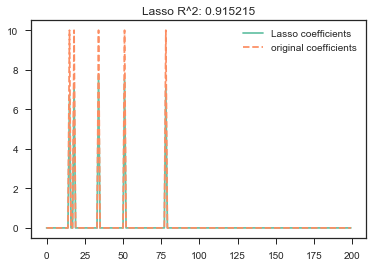

In [57]:
# We plot the results
plt.plot(lasso.coef_, label='Lasso coefficients')
plt.plot(coef, '--', label='original coefficients')
plt.legend(loc='best')
plt.title("Lasso R^2: %f"
          % (r2_score_lasso))
plt.show()

In [58]:
# We note that with this regularizer, we are getting the correct
# support, i.e., the non-zeros are in the correct places.
# However, the values are too small.
# Why is this?
# It's exactly as we should expect: we are penalizing the absolute value.
# If we penalize too much, then we pull it towards zero.
# 
print(lasso.coef_)
print(coef)

[-0.         -0.          0.          0.          0.         -0.
 -0.         -0.         -0.          0.          0.          0.
 -0.         -0.         -0.          6.70348157  0.         -0.
  7.31737458  0.         -0.         -0.         -0.         -0.
  0.          0.         -0.          0.         -0.          0.
  0.         -0.         -0.          0.          7.7056361  -0.
 -0.         -0.          0.          0.         -0.          0.
 -0.          0.          0.         -0.          0.         -0.
  0.         -0.         -0.          7.51932417  0.          0.
  0.         -0.          0.         -0.         -0.         -0.
 -0.         -0.          0.          0.          0.         -0.
  0.         -0.         -0.         -0.          0.         -0.
 -0.         -0.         -0.          0.          0.         -0.
  7.06227282  0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.          0.          0.
 -0.          0.         

# Let's search over alphas and find the best one.

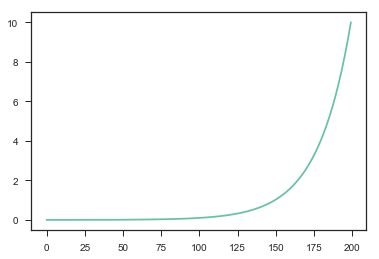

In [59]:
n_alphas = 200
alphas = np.logspace(-3, 1, n_alphas)
plt.plot(alphas)
#print(alphas)

In [60]:
coefs = []
r_sq = []
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)
    y_pred_lasso = lasso.fit(X_train, y_train).predict(X_test)
    r2_score_lasso = r2_score(y_test, y_pred_lasso)
    r_sq.append(r2_score_lasso)

    
###############################################################################
# Display results

#ax = plt.gca()
#ax.set_color_cycle(['b', 'r', 'g', 'c', 'k', 'y', 'm'])

#ax.plot(alphas, coefs)
#ax.set_xscale('log')
#plt.xlabel('alpha')
#plt.ylabel('weights')
#plt.title('Lasso coefficients as a function of the regularization')
#plt.axis('tight')
#plt.show()

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

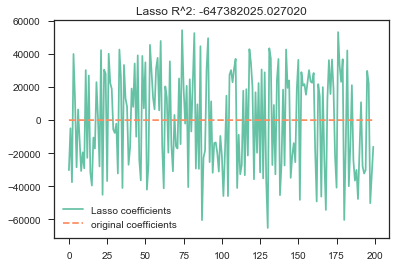

In [63]:
# This should be showing that for very small alpha, the solution is dense
# As alpha grows, we can see just a few of the coefficients separating out.
#
# Let's check
al = 10^-5
lasso = Lasso(alpha=al)

y_pred_lasso = lasso.fit(X_train, y_train).predict(X_test)
r2_score_lasso = r2_score(y_test, y_pred_lasso)
#print(lasso)
plt.plot(lasso.coef_, label='Lasso coefficients')
plt.plot(coef, '--', label='original coefficients')
plt.legend(loc='best')
plt.title("Lasso R^2: %f"
          % (r2_score_lasso))
plt.show()

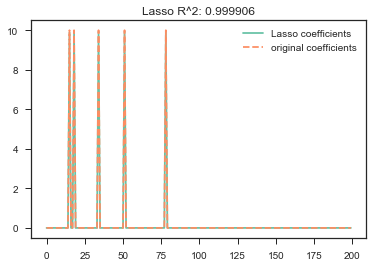

In [64]:
# We repeat for bigger alpha
#
alpha = 0.1
lasso = Lasso(alpha=alpha)

y_pred_lasso = lasso.fit(X_train, y_train).predict(X_test)
r2_score_lasso = r2_score(y_test, y_pred_lasso)
#print(lasso)
plt.plot(lasso.coef_, label='Lasso coefficients')
plt.plot(coef, '--', label='original coefficients')
plt.legend(loc='best')
plt.title("Lasso R^2: %f"
          % (r2_score_lasso))
plt.show()

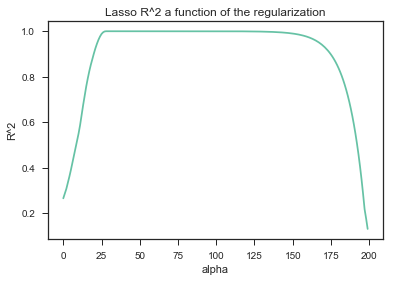

In [65]:
# Now let's plot the R^2 values
# Then we can use that to find the best alpha,
# i.e., the one that corresponds to largest R^2
plt.plot(r_sq)
ax.set_xscale('log')
#ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('R^2')
plt.title('Lasso R^2 a function of the regularization')
#plt.axis('tight')
plt.show()

In [66]:
# The largest R^2 value is almost equal to 1.
# We can find the alpha that corresponds to that.
print(max(r_sq))
index_max = np.argmax(r_sq)
print(index_max)
alphas[index_max]

0.9999998828668928
28


0.0036543830709572546

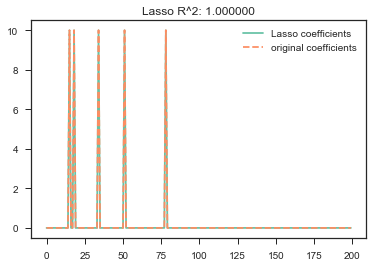

In [67]:
# Having found the best alpha, we can 
# repeat what we did above, using the "best" alpha
#
alpha = alphas[index_max]
lasso = Lasso(alpha=alpha)

y_pred_lasso = lasso.fit(X_train, y_train).predict(X_test)
r2_score_lasso = r2_score(y_test, y_pred_lasso)
#print(lasso)
plt.plot(lasso.coef_, label='Lasso coefficients')
plt.plot(coef, '--', label='original coefficients')
plt.legend(loc='best')
plt.title("Lasso R^2: %f"
          % (r2_score_lasso))
plt.show()

In [68]:
print(lasso.coef_)
print(coef)

[-0.         -0.          0.          0.          0.         -0.
 -0.         -0.         -0.          0.          0.          0.
 -0.         -0.         -0.          9.99626741  0.         -0.
  9.99687259  0.         -0.         -0.         -0.         -0.
  0.          0.         -0.          0.         -0.          0.
  0.         -0.          0.          0.          9.99707121 -0.
 -0.         -0.          0.          0.         -0.          0.
 -0.          0.          0.         -0.          0.         -0.
  0.         -0.         -0.          9.99704499  0.          0.
  0.         -0.          0.         -0.         -0.         -0.
  0.         -0.          0.          0.          0.         -0.
  0.         -0.         -0.         -0.          0.         -0.
 -0.         -0.         -0.          0.          0.         -0.
  9.99637984  0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.          0.          0.
 -0.          0.         

In [54]:
# Note that we now have the right locations of the nonzeros, 
# but without too much shrinkage towards zero.

# Parting thought: maybe we can use ideas from Lasso to recover the beta = [1,1,1,1,0] solution from above. Learn about and try using "Elastic Net" -- this combines Ridge and Lasso.